# Perception Control B - Analyses

# Analysis

In [1]:
from scipy import stats 
from functools import lru_cache
import json
import pandas as pd
import seaborn as sns
from msdm.domains import GridWorld
from vgc_project import gridutils, utils

In [2]:
survey_trials = pd.read_json("./data/all-survey-trials.json")
attn_trials = pd.read_json("./data/all-attention-trials.json")
mem_trials = pd.read_json("./data/all-memory-trials.json")

#apply exclusions
survey_trials = survey_trials[~survey_trials.exclude].reset_index(drop=True)
attn_trials = attn_trials[attn_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
mem_trials = mem_trials[mem_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)

In [3]:
print(f"Attention participants: {len(attn_trials.sessionId.unique())}")
print(f"Memory participants: {len(mem_trials.sessionId.unique())}")

Attention participants: 84
Memory participants: 87


## Compare with Experiment 3

In [4]:
EXP3_NAV_FILE = "../../experiments/exp3/data/results/navtrials.json"
EXP3_ATTN_FILE = "../../experiments/exp3/data/results/attentiontrials.json"
EXP3_MEM_FILE = "../../experiments/exp3/data/results/memorytrials.json"
exp3_at = pd.read_json(open(EXP3_ATTN_FILE, 'r'))
exp3_mt = pd.read_json(open(EXP3_MEM_FILE, 'r'))
exp3_nt = pd.read_json(open(EXP3_NAV_FILE, 'r'))

crit_obs = json.load(open("../mazes/mazes_12-15_crit_obs.json"))
basegrids = json.load(open("../mazes/mazes_12-15.json", 'r'))

In [5]:
#combine memory with navdists
# scale confidence back to 1 - 8
x = exp3_mt['conf'].values
x[x > 0] = x[x > 0] - 1
exp3_mt['conf'] = x + 5

# do other alignment things
exp3_mt = exp3_mt.rename(columns={'probeobs': 'obstacle'})
exp3_mt.obstacle = exp3_mt.obstacle.apply(str)
exp3_mt.grid = exp3_mt.grid.apply(lambda g: "grid-"+str(g))

exp5b_mt = mem_trials[['round', 'grid', 'obstacle','sessionId', 'correct', 'conf']].reset_index(drop=True)
exp5b_mt['obstacle'] = exp5b_mt['obstacle'].apply(str)

exp3_mt = exp3_mt[['round', 'grid', 'obstacle','sessionId', 'correct', 'conf']].reset_index(drop=True)

#check that they have same "support"
assert set(exp3_mt['conf'].unique()) == set(exp5b_mt['conf'].unique())
assert set(exp3_mt['obstacle'].unique()) == set(exp5b_mt['obstacle'].unique())
assert set(exp3_mt['grid'].unique()) == set(exp5b_mt['grid'].unique())

In [6]:
#combine attention w navdists
exp3_at['obstacle'] = exp3_at['probeobs']
exp3_at.grid = exp3_at.grid.apply(lambda g: "grid-"+str(g))
exp3_at = exp3_at[['round', 'grid', 'obstacle', 'sessionId', 'attention']].reset_index(drop=True)
exp3_at['obstacle'] = exp3_at['obstacle'].apply(str)

#scale
x = exp3_at['attention'].values
x[x > 0] = x[x > 0] - 1
exp3_at['attention'] = x + 5

exp5b_at = attn_trials[['round', 'grid', 'obstacle','sessionId', 'attn_resp']].rename(columns={'attn_resp':'attention'}).reset_index(drop=True)
exp5b_at['obstacle'] = exp5b_at['obstacle'].apply(str)

#check that they have same "support"
assert set(exp3_at['attention'].unique()) == set(exp5b_at['attention'].unique())
assert set(exp3_at['obstacle'].unique()) == set(exp5b_at['obstacle'].unique())
assert set(exp3_at['grid'].unique()) == set(exp5b_at['grid'].unique())

In [7]:
# combine memory into a single dataframe
comp_mt = pd.concat([
    exp3_mt.assign(exp="exp3"),
    exp5b_mt.assign(exp="exp5b")
]).reset_index(drop=True)
comp_mt['crit_obs'] = comp_mt.apply(lambda r: crit_obs[r.grid.replace("grid", "gridB")+"-0"][r.obstacle], axis=1)
comp_mt['conf_N'] = utils.normalize(comp_mt['conf'])

# combine attn into a single dataframe
comp_at = pd.concat([
    exp3_at.assign(exp="exp3"),
    exp5b_at.assign(exp="exp5b")
]).reset_index(drop=True)
comp_at['crit_obs'] = comp_at.apply(lambda r: crit_obs[r.grid.replace("grid", "gridB")+"-0"][r.obstacle], axis=1)
comp_at['attention_N'] = utils.normalize(comp_at['attention'])

In [8]:
from vgc_project.modelinterface import create_modeling_interface
from vgc_project import utils
mods = create_modeling_interface(joblib_cache_location="../../experiments/_analysiscache")

model_preds = []
for _, (gn, obs) in comp_at[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
comp_at = pd.concat([
    comp_at,
    pd.DataFrame(model_preds)
], axis=1)
comp_at['neg_optpolicy_dist'] = -comp_at['optpolicy_dist']

model_preds = []
for _, (gn, obs) in comp_mt[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
comp_mt = pd.concat([
    comp_mt,
    pd.DataFrame(model_preds)
], axis=1)
comp_mt['neg_optpolicy_dist'] = -comp_mt['optpolicy_dist']

to_zscore = [
    'vgc_weight',
    'value_mix_weight',
    'graph_based_hitcount',
    'goal_dist',
    'start_dist',
    'optpolicy_dist',
    'neg_optpolicy_dist',
    'walls_dist',
    'center_dist',
    'bottleneck_dist',
    'sr_occ',
    'log_traj_based_hitcount'
]
for col in to_zscore:
    comp_at[col+"_Z"] = utils.zscore(comp_at[col])
    comp_mt[col+"_Z"] = utils.zscore(comp_mt[col])

In [17]:
exp3_mt

,round,grid,obstacle,sessionId,correct,conf
0,0,grid-12,0,1tFfBDRFe1,True,6
1,0,grid-12,4,1tFfBDRFe1,False,7
2,0,grid-12,2,1tFfBDRFe1,True,5
3,0,grid-12,3,1tFfBDRFe1,True,5
4,0,grid-12,1,1tFfBDRFe1,True,1
...,...,...,...,...,...,...
3065,7,grid-14,3,7kUVsoXzOu,True,5
3066,7,grid-14,4,7kUVsoXzOu,True,5
3067,7,grid-14,2,7kUVsoXzOu,False,2
3068,7,grid-14,0,7kUVsoXzOu,True,6


In [9]:
%load_ext rpy2.ipython

In [10]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [18]:
%%R -i comp_at,comp_mt
# use sum coding for experiment comparison
comp_at$exp <- factor(comp_at$exp)
contrasts(comp_at$exp) <- contr.sum(2)
print(contrasts(comp_at$exp))

comp_mt$exp <- factor(comp_mt$exp)
contrasts(comp_mt$exp) <- contr.sum(2)
print(contrasts(comp_mt$exp))

      [,1]
exp3     1
exp5b   -1
      [,1]
exp3     1
exp5b   -1


In [20]:
%%R
full <- glmer(
    correct ~ (1 + round | sessionId) + exp*vgc_weight_Z,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ],
    family=binomial
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Models:
update(full, ~. - exp:vgc_weight_Z): correct ~ (1 + round | sessionId) + exp + vgc_weight_Z
full: correct ~ (1 + round | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  6 5257.8 5295.5 -2622.9   5245.8       
full                                 7 5258.0 5302.0 -2622.0   5244.0 1.8023
                                    Chi Df Pr(>Chisq)
update(full, ~. - exp:vgc_weight_Z)                  
full                                     1     0.1794
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ (1 + round | sessionId) + exp * vgc_weight_Z
   Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
    5258     5302  

In [28]:
%%R
full <- lmer(
    conf_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ],
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Models:
update(full, ~. - exp:vgc_weight_Z): conf_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df     AIC     BIC logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 -227.04 -195.66 118.52  -237.04       
full                                 6 -227.92 -190.26 119.96  -239.92 2.8826
                                    Chi Df Pr(>Chisq)  
update(full, ~. - exp:vgc_weight_Z)                    
full                                     1    0.08954 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df

In [29]:
%%R
full <- lmer(
    attention_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_at[comp_at$crit_obs %in% c("rel", "irrel"), ],
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_at[comp_at$crit_obs %in% c("rel", "irrel"), ]
Models:
update(full, ~. - exp:vgc_weight_Z): attention_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df     AIC     BIC logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 -528.34 -497.04 269.17  -538.34       
full                                 6 -536.88 -499.33 274.44  -548.88 10.547
                                    Chi Df Pr(>Chisq)   
update(full, ~. - exp:vgc_weight_Z)                     
full                                     1   0.001164 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_at[comp_at$crit_obs %in% c("rel", "irrel"), ]
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   

In [30]:
%%R
full <- glmer(
    correct ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt,
    family=binomial
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt
Models:
update(full, ~. - exp:vgc_weight_Z): correct ~ (1 | sessionId) + exp + vgc_weight_Z
full: correct ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  4 8228.2 8255.4 -4110.1   8220.2       
full                                 5 8179.6 8213.5 -4084.8   8169.6 50.654
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  1.102e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
  8179.6   8213.5  -4084.8   8169.6     6545 

Sca

In [31]:
%%R
full <- lmer(
    conf_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt,
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt
Models:
update(full, ~. - exp:vgc_weight_Z): conf_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df     AIC     BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 -187.89 -153.95  98.944  -197.89       
full                                 6 -372.22 -331.49 192.108  -384.22 186.33
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
  -372.2   -331.5    192.1   -384.2     6544 

Scaled residuals: 
   

In [32]:
%%R
full <- lmer(
    attention_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_at,
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_at
Models:
update(full, ~. - exp:vgc_weight_Z): attention_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df     AIC     BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 1338.71 1372.56 -664.36  1328.71       
full                                 6  654.89  695.51 -321.45   642.89 685.82
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_at
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
   654.9    695.5   -321.4    642.9     6434 

Scaled 

In [17]:
%%R
full <- glmer(
    correct ~ (1 | sessionId) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_optpolicy_dist_Z
        )
    ,
    data=comp_mt,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    family=binomial
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_mt
Models:
lesioned: correct ~ (1 | sessionId) + exp + vgc_weight_Z + graph_based_hitcount_Z + 
lesioned:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
lesioned:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
lesioned:     neg_optpolicy_dist_Z + exp:graph_based_hitcount_Z + exp:log_traj_based_hitcount_Z + 
lesioned:     exp:goal_dist_Z + exp:start_dist_Z + exp:walls_dist_Z + exp:center_dist_Z + 
lesioned:     exp:bottleneck_dist_Z + exp:sr_occ_Z + exp:neg_optpolicy_dist_Z
full: correct ~ (1 | sessionId) + exp * (vgc_weight_Z + graph_based_hitcount_Z + 
full:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
full:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
full:     neg_optpolicy_dist_Z)
         Df    AIC  BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 22 8118.7 8268 -4037.4   8074.7                             
full     23 8108.9 8265 -4031.5   8062.9 11.819      1  0.0005862 ***
---
Signif.

R[write to console]: 
Correlation matrix not shown by default, as p = 22 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [33]:
%%R
full <- lmer(
    conf_N ~ (1 | sessionId) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_optpolicy_dist_Z
        )
    ,
    data=comp_mt,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    REML=F
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_mt
Models:
lesioned: conf_N ~ (1 | sessionId) + exp + vgc_weight_Z + graph_based_hitcount_Z + 
lesioned:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
lesioned:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
lesioned:     neg_optpolicy_dist_Z + exp:graph_based_hitcount_Z + exp:log_traj_based_hitcount_Z + 
lesioned:     exp:goal_dist_Z + exp:start_dist_Z + exp:walls_dist_Z + exp:center_dist_Z + 
lesioned:     exp:bottleneck_dist_Z + exp:sr_occ_Z + exp:neg_optpolicy_dist_Z
full: conf_N ~ (1 | sessionId) + exp * (vgc_weight_Z + graph_based_hitcount_Z + 
full:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
full:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
full:     neg_optpolicy_dist_Z)
         Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 23 -692.94 -536.83 369.47  -738.94                             
full     24 -752.06 -589.16 400.03  -800.06 61.118      1  5.375e-15 ***
---


R[write to console]: 
Correlation matrix not shown by default, as p = 22 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [34]:
%%R
full <- lmer(
    attention_N ~ (1 | sessionId) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_optpolicy_dist_Z
        )
    ,
    data=comp_at,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    REML=F
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_at
Models:
lesioned: attention_N ~ (1 | sessionId) + exp + vgc_weight_Z + graph_based_hitcount_Z + 
lesioned:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
lesioned:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
lesioned:     neg_optpolicy_dist_Z + exp:graph_based_hitcount_Z + exp:log_traj_based_hitcount_Z + 
lesioned:     exp:goal_dist_Z + exp:start_dist_Z + exp:walls_dist_Z + exp:center_dist_Z + 
lesioned:     exp:bottleneck_dist_Z + exp:sr_occ_Z + exp:neg_optpolicy_dist_Z
full: attention_N ~ (1 | sessionId) + exp * (vgc_weight_Z + graph_based_hitcount_Z + 
full:     log_traj_based_hitcount_Z + goal_dist_Z + start_dist_Z + 
full:     walls_dist_Z + center_dist_Z + bottleneck_dist_Z + sr_occ_Z + 
full:     neg_optpolicy_dist_Z)
         Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 23 -365.53 -209.81 205.76  -411.53                             
full     24 -545.58 -383.10 296.79  -593.58 182.05      1  < 2.2e-1

R[write to console]: 
Correlation matrix not shown by default, as p = 22 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




# Visualizations

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

In [22]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue

def plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=False, number_fontsize=15, number_format="f"):
    fc = {o: color_mix((v - vmin)/(vmax - vmin)) for o, v in values.items()}
    gw = GridWorld(tile_array, absorbing_features=('G', ), initial_features=('S',))
    start = gw.initial_states[0]
    goal = gw.absorbing_states[0]
    gwp = gw.plot(featurecolors=fc, ax=ax, plot_initial_states=False, plot_absorbing_states=False).\
        annotate(start, text="S", fontsize=30, fontfamily="Courier New", weight='bold').\
        annotate(goal, text="G", fontsize=30, fontfamily="Courier New", weight='bold')
    if show_numbers:
        marked = []
        for loc, f in gw.location_features.items():
            if (f in fc) and (f not in marked):
                marked.append(f)
                if number_format == 'f':
                    if 0 < values[f] < 1.0:
                        text = f"{values[f]:.2f}".lstrip("0")
                    else: 
                        text = f"{values[f]:.1f}"
                elif number_format == 'g':
                    text = ("%.2g" % values[f]).replace("-0","-").lstrip("0")
                gwp.annotate(loc, 
                             text=text,
                             fontsize=number_fontsize,
                             weight='bold',
                             color='w' if ((values[f] - vmin)/(vmax - vmin)) > .5 else 'k')
        
    if title:
        gwp.title(f"{title}", fontsize=30)

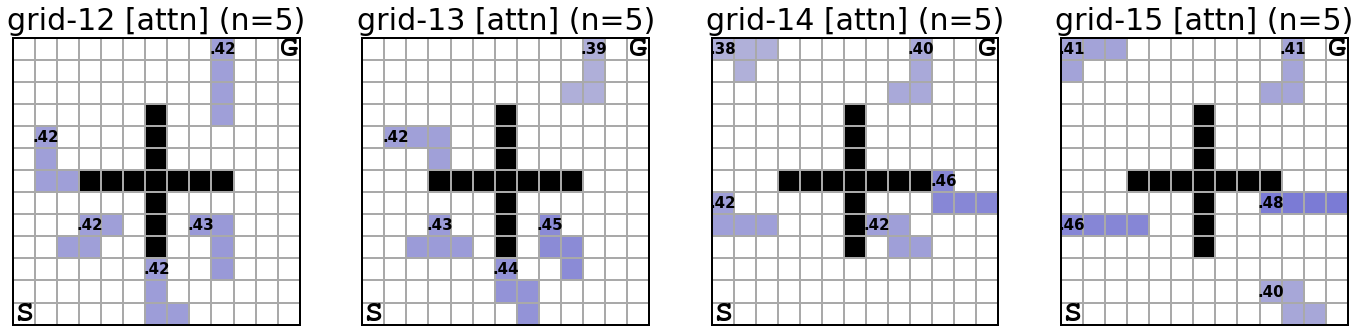

In [23]:
to_plot = attn_trials.groupby(['grid', 'obstacle'])['attn_resp_N'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [attn] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

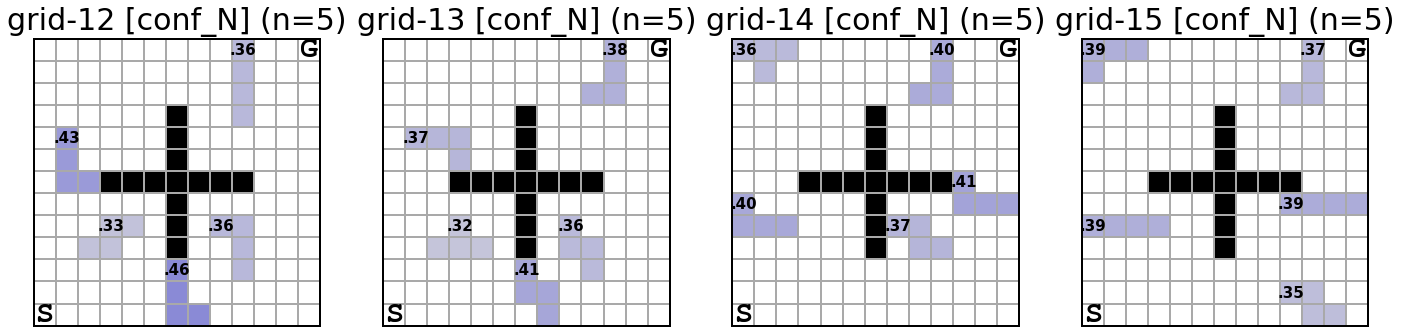

In [24]:
to_plot = mem_trials.groupby(['grid', 'obstacle'])['conf_N'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [conf_N] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

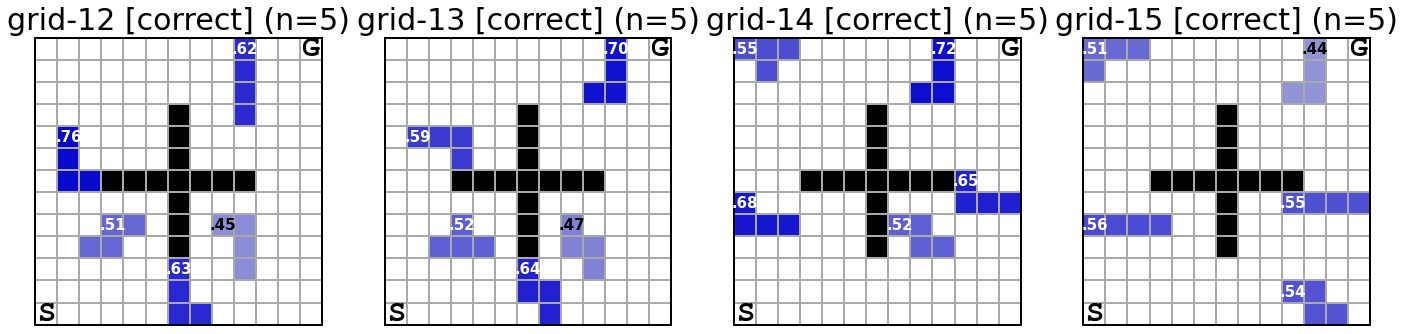

In [25]:
to_plot = mem_trials.groupby(['grid', 'obstacle'])['correct'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [correct] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

Text(0.5, 1.0, 'Perceptual Control B')

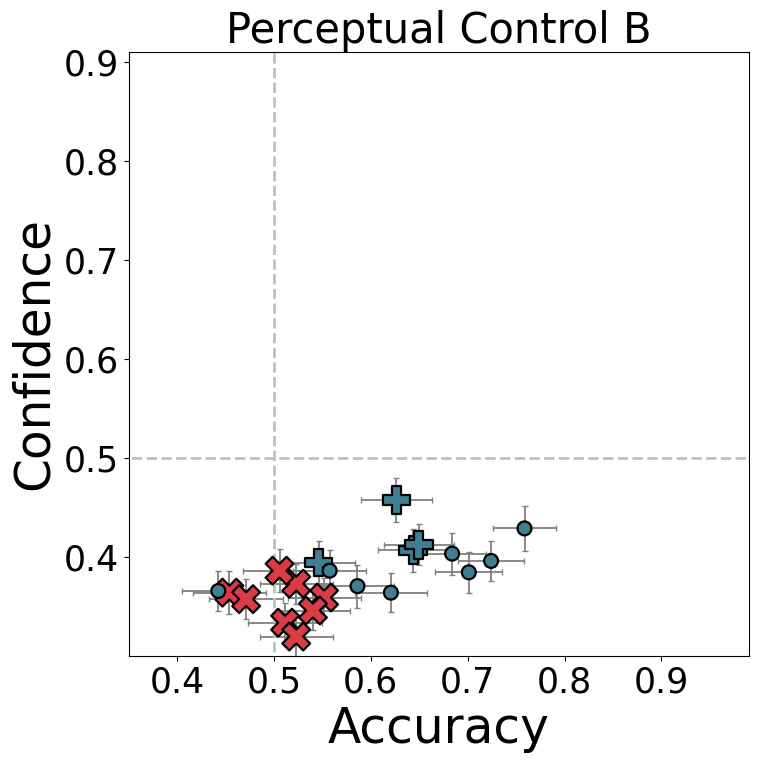

In [26]:
def bin_confint(v, z=1):
    """normal approximation interval for binomial confidence interval"""
    return z*np.sqrt(np.mean(v)*(1-np.mean(v))/len(v))
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
to_plot = pd.concat([
    comp_mt[comp_mt['exp'] == "exp5b"].groupby(['grid', 'obstacle'])[['correct', 'conf_N']].mean(),
    comp_mt[comp_mt['exp'] == "exp5b"].groupby(['grid', 'obstacle'])['vgc_weight'].mean(),
    comp_mt[comp_mt['exp'] == "exp5b"].groupby(['grid', 'obstacle'])['crit_obs'].apply(lambda rs: rs.iloc[0])
], axis=1)
to_plot_err = pd.concat([
    comp_mt[comp_mt['exp'] == "exp5b"].groupby(['grid', 'obstacle'])['correct'].agg(bin_confint).rename("correct_sem"),
    comp_mt[comp_mt['exp'] == "exp5b"].groupby(['grid', 'obstacle'])['conf_N'].sem().rename("conf_N_sem"),
], axis=1)
plt.errorbar(
    x=to_plot['correct'], y=to_plot['conf_N'],
    xerr=to_plot_err['correct_sem'], yerr=to_plot_err['conf_N_sem'], 
    fmt='none',
    ecolor='grey', 
    zorder=-1,
    capsize=2,
    linewidth=1.3
)
cmap = sns.diverging_palette(10, 220, as_cmap=True)
plt.plot([.5, .5], [.2, 1.0], color='silver', linestyle='--', zorder=-1, linewidth=2)
plt.plot([.2, 1.0], [.5, .5], color='silver', linestyle='--', zorder=-1, linewidth=2)
g = sns.scatterplot(data=to_plot, 
                    x='correct', y='conf_N', hue='vgc_weight', style='crit_obs',
                    markers={'irrel': 'X', 'rel': 'P', 'none': '.'},
                    palette=cmap, ec='k',
                    ax=ax, 
                    s=400,
                    hue_norm=(0, 1),
                   )
plt.ylim(.3, .91)
plt.xlim(.35, .99)

g.set_xlabel("Accuracy", fontsize=35)
g.set_ylabel("Confidence", fontsize=35)
g.set_xticks([.4, .5, .6, .7, .8, .9])
g.set_yticks([.4, .5, .6, .7, .8, .9])
g.tick_params(axis='y', labelsize=25)
g.tick_params(axis='x', labelsize=25)
g.legend_.remove()
g.set_title("Perceptual Control B", fontsize=30)